# emcee document
https://emcee.readthedocs.io/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Example: Fitting a Model to Data
https://emcee.readthedocs.io/en/v2.2.1/user/line/

In [101]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

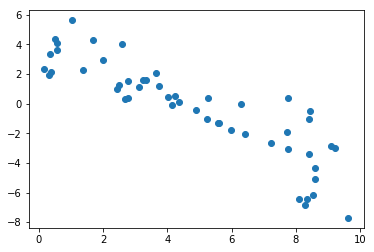

In [102]:
plt.scatter(x,y)
plt.show()

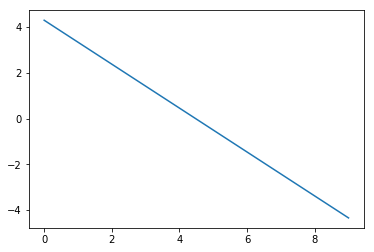

In [103]:
x_truemodel = np.array(range(10))
y_truemodel = m_true*x_truemodel+b_true
plt.plot(x_truemodel,y_truemodel)
plt.show()

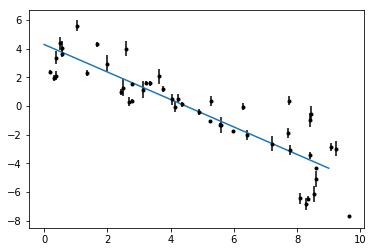

In [104]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
x_truemodel = np.array(range(10))
y_truemodel = m_true*x_truemodel+b_true
plt.plot(x_truemodel,y_truemodel)
plt.show()

# Linear least squares
## ref
- Data analysis recipes: Fitting a model to data∗
 - Hogg et.al. 2010
 - https://arxiv.org/pdf/1008.4686.pdf
 - refer p4

In [105]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

In [106]:
np.diag(yerr * yerr)

array([[ 0.01412806,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.05110034,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.22775963, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.08238333,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.2697343 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.01205092]])

In [107]:
print('b_ls=%f, m_ls=%f' % (b_ls, m_ls))

b_ls=4.146267, m_ls=-1.023796


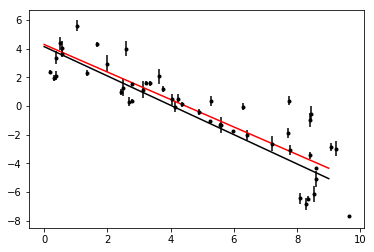

In [108]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

x_truemodel = np.array(range(10))
y_truemodel = m_true*x_truemodel+b_true
plt.plot(x_truemodel,y_truemodel, color="r")

x_ls= np.array(range(10))
y_ls = m_ls*x_ls+b_ls
plt.plot(x_ls,y_ls, color="k")

plt.show()

# Maximum Likelihood estimation
likelihood function is simply a Gaussian where the variance is underestimated by some fractional amount: f.

## ref
### scipy.optimize.minimum
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

In [109]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    #m, b, f = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    #inv_sigma2 = 1.0/(yerr**2 + model**2*(f**2))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [110]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
#result = op.minimize(nll, [m_true, b_true, f_true], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
#m_ml, b_ml, f_ml = result["x"]

In [111]:
print('m_ml=%f, b_ml=%f, f_ml=%f' % (m_ml, b_ml, np.exp(lnf_ml)))
#print('m_ml=%f, b_ml=%f, f_ml=%f' % (m_ml, b_ml, f_ml))

m_ml=-0.957929, b_ml=4.329288, f_ml=0.536486


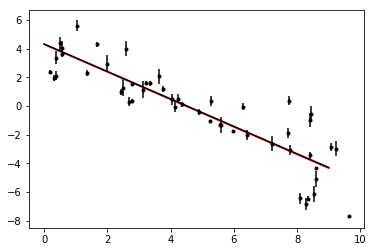

In [112]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

x_truemodel = np.array(range(10))
y_truemodel = m_true*x_truemodel+b_true
plt.plot(x_truemodel,y_truemodel, color="r")

x_ml = np.array(range(10))
y_ml = m_ml*x_ml+b_ml
plt.plot(x_ml,y_ml, color="k")

plt.show()

# Marginalization & uncertainty estimation

In [113]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [114]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [115]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [116]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [117]:
sampler.run_mcmc(pos, 500)

(array([[-1.04473339,  4.69174353, -0.51829207],
        [-1.0192869 ,  4.44492699, -0.82630089],
        [-0.91287874,  4.06162531, -0.72179062],
        [-0.84326836,  3.91570946, -0.477447  ],
        [-0.97522018,  4.38410898, -0.88056556],
        [-0.72596906,  3.34763599, -0.28098591],
        [-0.98716731,  4.33880891, -0.49714655],
        [-1.02218618,  4.78043884, -0.59479367],
        [-0.9747727 ,  4.46012854, -0.6296959 ],
        [-1.06961308,  4.87214029, -0.73882292],
        [-1.00722597,  4.54357336, -0.64417923],
        [-1.04983467,  4.7675899 , -0.70808896],
        [-0.84843026,  3.86897272, -0.57139989],
        [-1.03141378,  4.54901677, -0.76656627],
        [-0.93796602,  4.31599013, -0.86515236],
        [-0.92654156,  4.27578793, -0.65005534],
        [-0.99840673,  4.59903149, -0.72699712],
        [-0.87675109,  3.95037883, -0.47184662],
        [-0.96797461,  4.24184949, -0.48673897],
        [-0.88984965,  4.12904302, -0.62821786],
        [-0.94450133

In [118]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

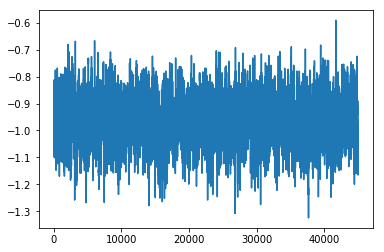

In [119]:
plt.plot(samples[:,0])
plt.show()

In [123]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("../output/triangle.png")

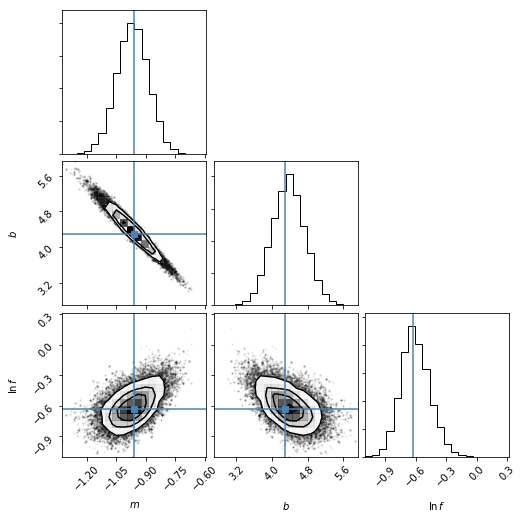

In [121]:
plt.show()

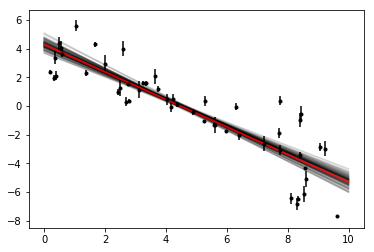

In [122]:
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.show()